In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')


#install library ekphrasis

In [3]:
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [4]:
#Proses Penataan Data dengan memanfaatkan library ekprasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


#Load Library

In [5]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#Load dataset mentah

In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/diaduk_UTS_AMS.csv', encoding=('ISO-8859-1'), low_memory=False, sep=';')  

#cek info

In [7]:
df.head()

,Tweets,Labels
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0
1,"@tennierubyten Sambil makan bubur, diaduk",1
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  99 non-null     object
 1   Labels  99 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


#Preprocessing

##setting fungsi

In [9]:
#membersihkan data dengan menghilangkan emoji, rt, mention, dll
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text) 

##running preprocessing

In [10]:
final_string = []
for text in df['Tweets'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [11]:
df["step01"] = final_string

In [12]:
df.head()

,Tweets,Labels,step01
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0,user allcaps siapa yang ngide makan bubur diad...
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0,kenapa ini game dari bubur diaduk bubur diseru...
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  99 non-null     object
 1   Labels  99 non-null     int64 
 2   step01  99 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


##hapus record yang kosong

In [14]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [15]:
df_new = df[~df.isin(df_hapus)].dropna()

In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  99 non-null     object
 1   Labels  99 non-null     int64 
 2   step01  99 non-null     object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


##normalisasi kata slang

In [17]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [19]:
#memisahkan teks menjadi token-token
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [20]:
df_new.head(100)

,Tweets,Labels,step01,tokens
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0,user allcaps siapa yang ngide makan bubur diad...,"[user, allcaps, siapa, yang, ngide, makan, bub..."
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk,"[user, sambil, makan, bubur, diaduk]"
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0,kenapa ini game dari bubur diaduk bubur diseru...,"[kenapa, ini, game, dari, bubur, diaduk, bubur..."
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...,"[rt, user, mile, kalo, kulit, ayam, mcd, nya, ..."
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk,"[user, user, tuh, user, penikmat, bubur, ayam,..."
...,...,...,...,...
94,"@convomfs Bubur gak diaduk, kalo diaduk kek mu...",0,user bubur gak diaduk kalo diaduk kek muntahan...,"[user, bubur, gak, diaduk, kalo, diaduk, kek, ..."
95,"Pantes ngaco, liat bionya ini orang makan bubu...",0,pantes ngaco liat bionya ini orang makan bubur...,"[pantes, ngaco, liat, bionya, ini, orang, maka..."
96,@convomfs Nder lu pasti sekte bubur gak diaduk...,0,user nder lu pasti sekte bubur gak diaduk kan ...,"[user, nder, lu, pasti, sekte, bubur, gak, dia..."
97,bubur gak diaduk hny utk org denial,0,bubur gak diaduk hny utk org denial,"[bubur, gak, diaduk, hny, utk, org, denial]"


In [21]:
normalized_word = pd.read_excel("/content/drive/My Drive/Colab Notebooks/kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [22]:
df_new.head()

,Tweets,Labels,step01,tokens,tokens_perbaikan
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0,user allcaps siapa yang ngide makan bubur diad...,"[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, siapa, yang, ngide, makan, bub..."
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk,"[user, sambil, makan, bubur, diaduk]","[user, sambil, makan, bubur, diaduk]"
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0,kenapa ini game dari bubur diaduk bubur diseru...,"[kenapa, ini, game, dari, bubur, diaduk, bubur...","[kenapa, ini, game, dari, bubur, diaduk, bubur..."
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...,"[rt, user, mile, kalo, kulit, ayam, mcd, nya, ...","[rt, user, mile, kalau, kulit, ayam, mcd, nya,..."
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk,"[user, user, tuh, user, penikmat, bubur, ayam,...","[user, user, itu, user, penikmat, bubur, ayam,..."


In [23]:
#menyeleksi data pada index ke 0
df_new.iloc[0].tokens

['user',
 'allcaps',
 'siapa',
 'yang',
 'ngide',
 'makan',
 'bubur',
 'diaduk',
 'sih',
 'allcaps']

In [24]:
df_new.iloc[0].tokens_perbaikan

['user',
 'allcaps',
 'siapa',
 'yang',
 'ngide',
 'makan',
 'bubur',
 'diaduk',
 'sih',
 'allcaps']

##Stopword - Menggunakan Modul NLTK

In [25]:
#menghilangkan kata kata tdk penting
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Tweets,Labels,step01,tokens,tokens_perbaikan,Stop_removal
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0,user allcaps siapa yang ngide makan bubur diad...,"[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, ngide, makan, bubur, diaduk, s..."
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk,"[user, sambil, makan, bubur, diaduk]","[user, sambil, makan, bubur, diaduk]","[user, makan, bubur, diaduk]"
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0,kenapa ini game dari bubur diaduk bubur diseru...,"[kenapa, ini, game, dari, bubur, diaduk, bubur...","[kenapa, ini, game, dari, bubur, diaduk, bubur...","[game, bubur, diaduk, bubur, diseruput, doi, f..."
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...,"[rt, user, mile, kalo, kulit, ayam, mcd, nya, ...","[rt, user, mile, kalau, kulit, ayam, mcd, nya,...","[rt, user, mile, kulit, ayam, mcd, nya, ngantr..."
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk,"[user, user, tuh, user, penikmat, bubur, ayam,...","[user, user, itu, user, penikmat, bubur, ayam,...","[user, user, user, penikmat, bubur, ayam, diaduk]"
...,...,...,...,...,...,...
94,"@convomfs Bubur gak diaduk, kalo diaduk kek mu...",0,user bubur gak diaduk kalo diaduk kek muntahan...,"[user, bubur, gak, diaduk, kalo, diaduk, kek, ...","[user, bubur, tidak, diaduk, kalau, diaduk, ka...","[user, bubur, diaduk, diaduk, kayak, muntahan,..."
95,"Pantes ngaco, liat bionya ini orang makan bubu...",0,pantes ngaco liat bionya ini orang makan bubur...,"[pantes, ngaco, liat, bionya, ini, orang, maka...","[pantas, kacau, lihat, bionya, ini, orang, mak...","[kacau, lihat, bionya, orang, makan, bubur, di..."
96,@convomfs Nder lu pasti sekte bubur gak diaduk...,0,user nder lu pasti sekte bubur gak diaduk kan ...,"[user, nder, lu, pasti, sekte, bubur, gak, dia...","[user, nder, kamu, pasti, sekte, bubur, tidak,...","[user, nder, sekte, bubur, diaduk, mie, aduk]"
97,bubur gak diaduk hny utk org denial,0,bubur gak diaduk hny utk org denial,"[bubur, gak, diaduk, hny, utk, org, denial]","[bubur, tidak, diaduk, hanya, untuk, orang, de...","[bubur, diaduk, orang, denial]"


In [27]:
df_new.iloc[1].tokens_perbaikan

['user', 'sambil', 'makan', 'bubur', 'diaduk']

In [28]:
df_new.iloc[1].Stop_removal

['user', 'makan', 'bubur', 'diaduk']

In [29]:
#yang awalnya berbentuk token, maka akan digabung lagi menjadi bentuk dokumen
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [30]:
df_new["step02"] = final_string_tokens

In [31]:
df_new.head()

,Tweets,Labels,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0,user allcaps siapa yang ngide makan bubur diad...,"[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, ngide, makan, bubur, diaduk, s...",user allcaps ngide makan bubur diaduk sih allcaps
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk,"[user, sambil, makan, bubur, diaduk]","[user, sambil, makan, bubur, diaduk]","[user, makan, bubur, diaduk]",user makan bubur diaduk
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0,kenapa ini game dari bubur diaduk bubur diseru...,"[kenapa, ini, game, dari, bubur, diaduk, bubur...","[kenapa, ini, game, dari, bubur, diaduk, bubur...","[game, bubur, diaduk, bubur, diseruput, doi, f...",game bubur diaduk bubur diseruput doi fall out...
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...,"[rt, user, mile, kalo, kulit, ayam, mcd, nya, ...","[rt, user, mile, kalau, kulit, ayam, mcd, nya,...","[rt, user, mile, kulit, ayam, mcd, nya, ngantr...",rt user mile kulit ayam mcd nya ngantri mie ga...
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk,"[user, user, tuh, user, penikmat, bubur, ayam,...","[user, user, itu, user, penikmat, bubur, ayam,...","[user, user, user, penikmat, bubur, ayam, diaduk]",user user user penikmat bubur ayam diaduk


##Stemming - Menggunakan Sastrawi

In [32]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 28.7 MB/s 


In [33]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [34]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)
    
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [35]:
df_new["ProcessedText"] = final_string

In [36]:
df_new.head(5)

,Tweets,Labels,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,@seongwuuu95 SIAPA YANG NGIDE MAKAN BUBUR DIAD...,0,user allcaps siapa yang ngide makan bubur diad...,"[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, siapa, yang, ngide, makan, bub...","[user, allcaps, ngide, makan, bubur, diaduk, s...",user allcaps ngide makan bubur diaduk sih allcaps,user allcaps ngide makan bubur aduk sih allcaps
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk,"[user, sambil, makan, bubur, diaduk]","[user, sambil, makan, bubur, diaduk]","[user, makan, bubur, diaduk]",user makan bubur diaduk,user makan bubur aduk
2,Kenapa ini game dari bubur diaduk/bubur diseru...,0,kenapa ini game dari bubur diaduk bubur diseru...,"[kenapa, ini, game, dari, bubur, diaduk, bubur...","[kenapa, ini, game, dari, bubur, diaduk, bubur...","[game, bubur, diaduk, bubur, diseruput, doi, f...",game bubur diaduk bubur diseruput doi fall out...,game bubur aduk bubur seruput doi fall out lov...
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...,"[rt, user, mile, kalo, kulit, ayam, mcd, nya, ...","[rt, user, mile, kalau, kulit, ayam, mcd, nya,...","[rt, user, mile, kulit, ayam, mcd, nya, ngantr...",rt user mile kulit ayam mcd nya ngantri mie ga...,rt user mile kulit ayam mcd nya ngantri mie ga...
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk,"[user, user, tuh, user, penikmat, bubur, ayam,...","[user, user, itu, user, penikmat, bubur, ayam,...","[user, user, user, penikmat, bubur, ayam, diaduk]",user user user penikmat bubur ayam diaduk,user user user nikmat bubur ayam aduk


##simpan hasil preprocessing

In [37]:
df_new.to_csv('/content/drive/My Drive/Colab Notebooks/clean_dataset_part11.csv', sep=";")

##Penataan Data
pembagian fitur dan label

In [38]:
import pandas as pd
import numpy as np

In [39]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/clean_dataset_part11.csv', sep=";")

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        99 non-null     int64 
 1   Tweets            99 non-null     object
 2   Labels            99 non-null     int64 
 3   step01            99 non-null     object
 4   tokens            99 non-null     object
 5   tokens_perbaikan  99 non-null     object
 6   Stop_removal      99 non-null     object
 7   step02            99 non-null     object
 8   ProcessedText     99 non-null     object
dtypes: int64(2), object(7)
memory usage: 7.1+ KB


In [41]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [42]:
dataset_feature.head(10)

0      user allcaps ngide makan bubur aduk sih allcaps
1                                user makan bubur aduk
2    game bubur aduk bubur seruput doi fall out lov...
3    rt user mile kulit ayam mcd nya ngantri mie ga...
4                user user user nikmat bubur ayam aduk
5               user apkh sekte bubur aduk iyh ngepens
6    user user allcaps lmao allcaps baik tumpah bub...
7                    bubur aduk enak aduk cok227kxg2qo
8                 user allcaps enak bubur aduk allcaps
9                     user user orgil makan bubur aduk
Name: ProcessedText, dtype: object

In [43]:
dataset_label = dataset['Labels']

In [44]:
dataset_label.head(10)

0    0
1    1
2    0
3    1
4    1
5    1
6    1
7    0
8    1
9    0
Name: Labels, dtype: int64

##distribusi label

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


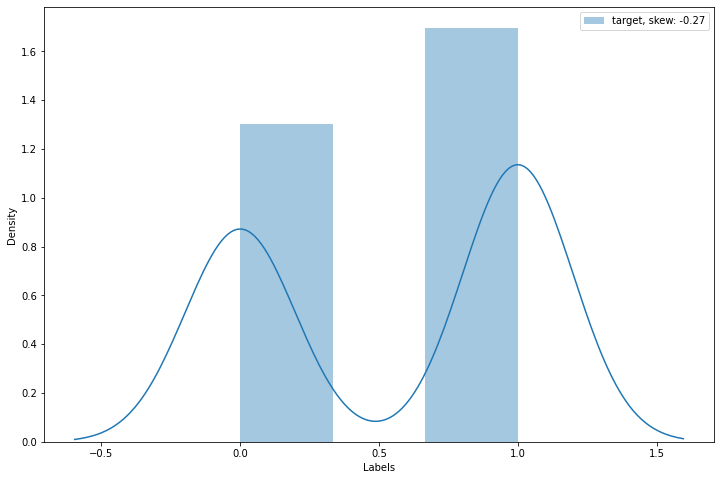

In [46]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [47]:
dataset_label.value_counts()

1    56
0    43
Name: Labels, dtype: int64

Kesimpulan dataset : Data yang digunakan dalam analisis ini memiliki 2 sentimen yaitu positif dan negatif dimana masing-masing distribusi data berjumlah 56 dan 43. dapat dilihat bahwa jumlah masing-masing label cukup seimbang dan tidak ada ketimpangan sehingga data cukup optimal untuk dilakukan pemodelan.

##Ekstraksi Fitur dan Machine Learning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [49]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [50]:
test_x

62    user jaga indah aesthetic bubur ayam unsur lez...
40                                user makan bubur aduk
95    kacau lihat bionya orang makan bubur aduk co6b...
18                user ampuun tim bubur aduk marahin ya
97                              bubur aduk orang denial
84               bubur aduk jaya jaya jaya coiokavauqf1
64    user aduh tim bubur aduk sedot habis selesai m...
42    user mo aduk ato sih preferensi khusus makan b...
10                                   bubur aduk or aduk
0       user allcaps ngide makan bubur aduk sih allcaps
31                            user iya pokok bubur aduk
76    user tim bubur aduk aduk estetik kayak makan ayam
47    user matchanya manis sih bitter nya banget hin...
26        user kate ngelindur sarap bubur ayam tim aduk
44                 tim bubur aduk asa aduk coj91wv9lp51
4                 user user user nikmat bubur ayam aduk
22    user iya ya bubur aduk ngeri banget bentuk all...
12                                user bubur adu

##load TF-IDF

In [51]:
#menentukan nilai frekuensi sebuah kata
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

In [52]:
positive_reviews = df_new[(df_new["Labels"] == 1)]
negative_reviews = df_new[(df_new["Labels"] == 0)]

##cek emosi positive

In [53]:
positive_reviews.head()

,Tweets,Labels,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
1,"@tennierubyten Sambil makan bubur, diaduk",1,user sambil makan bubur diaduk,"[user, sambil, makan, bubur, diaduk]","[user, sambil, makan, bubur, diaduk]","[user, makan, bubur, diaduk]",user makan bubur diaduk,user makan bubur aduk
3,RT @fantabeku: mile kalo kulit ayam mcd nya di...,1,rt user mile kalo kulit ayam mcd nya diminta n...,"[rt, user, mile, kalo, kulit, ayam, mcd, nya, ...","[rt, user, mile, kalau, kulit, ayam, mcd, nya,...","[rt, user, mile, kulit, ayam, mcd, nya, ngantr...",rt user mile kulit ayam mcd nya ngantri mie ga...,rt user mile kulit ayam mcd nya ngantri mie ga...
4,@Ken_Atie @Iyaaaa_iniaku Tuh @Nisaa_C_Almeer ...,1,user user tuh user penikmat bubur ayam diaduk,"[user, user, tuh, user, penikmat, bubur, ayam,...","[user, user, itu, user, penikmat, bubur, ayam,...","[user, user, user, penikmat, bubur, ayam, diaduk]",user user user penikmat bubur ayam diaduk,user user user nikmat bubur ayam aduk
5,@cimolasin apkh km sekte bubur diaduk? klo iyh...,1,user apkh km sekte bubur diaduk klo iyh ak aka...,"[user, apkh, km, sekte, bubur, diaduk, klo, iy...","[user, apkh, kamu, sekte, bubur, diaduk, kalau...","[user, apkh, sekte, bubur, diaduk, iyh, ngepens]",user apkh sekte bubur diaduk iyh ngepens,user apkh sekte bubur aduk iyh ngepens
6,@bittrefIy @ssefnum LMAO gapapa pertumpahan bu...,1,user user allcaps lmao allcaps gapapa pertumpa...,"[user, user, allcaps, lmao, allcaps, gapapa, p...","[user, user, allcaps, lmao, allcaps, baik , pe...","[user, user, allcaps, lmao, allcaps, baik , pe...",user user allcaps lmao allcaps baik pertumpah...,user user allcaps lmao allcaps baik tumpah bub...


In [54]:
Positive_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
Positive_1_tf_idf = Positive_1_tf_idf_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [55]:
Positive_1_tf_idf.shape

(56, 418)

In [56]:
features = Positive_1_tf_idf_vect.get_feature_names()

idfValues = Positive_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

('bubur', 8.0)
('aduk', 7.982300422900599)
('bubur aduk', 7.741138366083711)
('user', 7.620510378295096)
('makan', 6.521898089626987)
('user bubur', 6.521898089626987)
('makan bubur', 6.4418553819534505)
('tim', 6.4418553819534505)
('tim bubur', 6.35484400496382)
('ayam', 6.036390273845286)
('bubur ayam', 5.902858881220763)
('user user', 5.902858881220763)
('ya', 5.748708201393505)
('allcaps', 5.56638664459955)
('ayam aduk', 5.56638664459955)
('enak', 5.56638664459955)
('rt', 5.56638664459955)
('rt user', 5.56638664459955)
('user tim', 5.56638664459955)
('aduk aduk', 5.3432430932853405)
('aduk bubur', 5.3432430932853405)
('sarap', 5.3432430932853405)
('tau', 5.3432430932853405)
('user allcaps', 5.3432430932853405)
('aduk ato', 5.05556102083356)
('aduk bingung', 5.05556102083356)
('aduk sedot', 5.05556102083356)
('aduk ya', 5.05556102083356)
('ato', 5.05556102083356)
('bingung', 5.05556102083356)
('bingung ya', 5.05556102083356)
('cowsu9lgvndu', 5.05556102083356)
('egk', 5.0555610208335

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [58]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

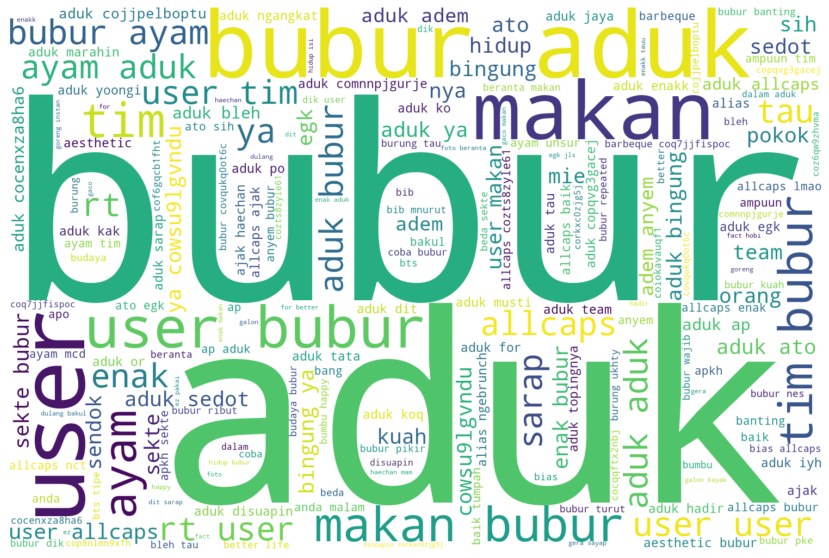

In [59]:
PlotWordCloud(d)

##cek emosi negative

In [60]:
negative_reviews = df_new[(df_new["Labels"] == 0)]

In [61]:
Negative_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
Negative_1_tf_idf = Negative_1_tf_idf_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [62]:
Negative_1_tf_idf.shape

(43, 347)

In [63]:
features = Negative_1_tf_idf_vect.get_feature_names()

idfValues = Negative_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

('aduk', 7.977010481775301)
('bubur', 7.977010481775301)
('bubur aduk', 7.853396525808124)
('user', 7.548014876256943)
('makan', 7.21154263963573)
('makan bubur', 6.98839908832152)
('tim', 6.518395459075784)
('aduk aduk', 6.4130349434179585)
('allcaps', 6.4130349434179585)
('tim bubur', 6.4130349434179585)
('kayak', 6.295251907761575)
('aduk allcaps', 6.161720515137052)
('orang', 6.161720515137052)
('elongated', 6.007569835309794)
('orang makan', 6.007569835309794)
('repeated', 6.007569835309794)
('ayam', 5.825248278515839)
('enak', 5.825248278515839)
('user bubur', 5.825248278515839)
('aduk kayak', 5.602104727201629)
('aneh', 5.602104727201629)
('banget', 5.602104727201629)
('kayak makan', 5.602104727201629)
('muntah', 5.602104727201629)
('sih', 5.602104727201629)
('user allcaps', 5.602104727201629)
('user user', 5.602104727201629)
('aduk estetik', 5.3144226547498485)
('ayam aduk', 5.3144226547498485)
('bentuk', 5.3144226547498485)
('bubur ayam', 5.3144226547498485)
('elongated allcap

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [65]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

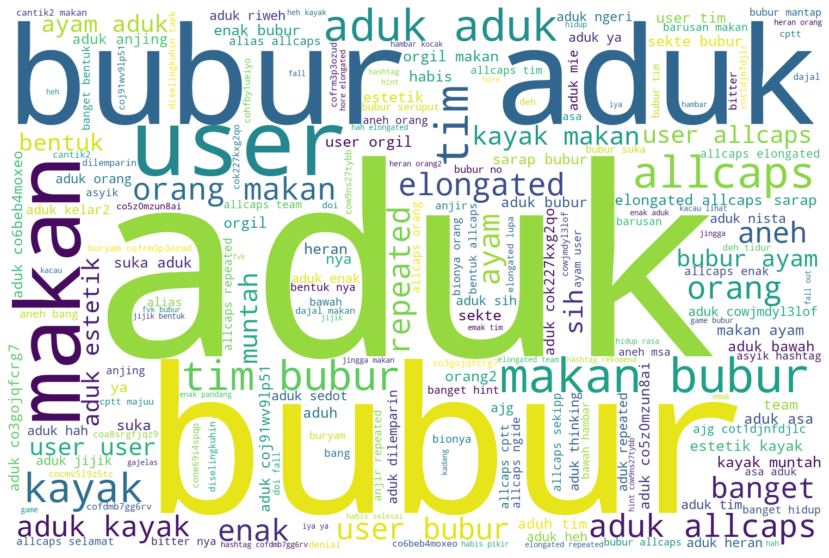

In [66]:
PlotWordCloud(d)

##Cek emosi untuk Semua label

In [67]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))

In [68]:
Data_TFIDF = tfidf_vect.fit_transform(df_new["ProcessedText"].values)

In [69]:
Data_TFIDF.shape

(99, 707)

In [70]:
vectorizer = TfidfVectorizer(ngram_range = (1,2))

In [71]:
X = vectorizer.fit_transform(df_new["ProcessedText"].values)

In [72]:
print(X.shape)

(99, 707)


In [73]:
features = vectorizer.get_feature_names_out()

In [74]:
features

array(['adem', 'adem anyem', 'aduh', 'aduh tim', 'aduk', 'aduk adem',
       'aduk aduk', 'aduk allcaps', 'aduk anjing', 'aduk ap', 'aduk asa',
       'aduk ato', 'aduk bawah', 'aduk bingung', 'aduk bleh',
       'aduk bubur', 'aduk co3gojqfcrg7', 'aduk co5z0mzun8ai',
       'aduk co6beb4moxeo', 'aduk cocenxza8ha6', 'aduk coj91wv9lp51',
       'aduk cojjpelboptu', 'aduk cok227kxg2qo', 'aduk comnnpjgurje',
       'aduk copqvg3gacej', 'aduk cowjmdyl3lof', 'aduk dilemparin',
       'aduk disuapin', 'aduk dit', 'aduk egk', 'aduk enak', 'aduk enakk',
       'aduk estetik', 'aduk for', 'aduk hadir', 'aduk hah', 'aduk heh',
       'aduk heran', 'aduk iyh', 'aduk jaya', 'aduk jijik', 'aduk kak',
       'aduk kayak', 'aduk kelar2', 'aduk ko', 'aduk koq', 'aduk marahin',
       'aduk mie', 'aduk musti', 'aduk ngangkat', 'aduk ngeri',
       'aduk nista', 'aduk or', 'aduk orang', 'aduk po', 'aduk repeated',
       'aduk riweh', 'aduk sarap', 'aduk sedot', 'aduk sih', 'aduk tata',
       'aduk tau

In [75]:
idfValues = vectorizer.idf_

In [76]:
d = dict(zip(features, 9 - idfValues))

In [77]:
sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

In [78]:
for i in range(651):
    print(sortedDict[i])

('bubur', 7.989949664146499)
('aduk', 7.9797972926824805)
('bubur aduk', 7.789278968684347)
('user', 7.584484556038334)
('makan', 6.860565716811635)
('makan bubur', 6.690666680016237)
('tim', 6.439352251735332)
('tim bubur', 6.339268793178349)
('user bubur', 6.228043158068124)
('allcaps', 5.959779171473445)
('aduk aduk', 5.879736463799909)
('ayam', 5.879736463799909)
('user user', 5.697414907005954)
('bubur ayam', 5.592054391348128)
('enak', 5.592054391348128)
('kayak', 5.592054391348128)
('orang', 5.592054391348128)
('aduk allcaps', 5.474271355691744)
('ya', 5.474271355691744)
('ayam aduk', 5.340739963067222)
('orang makan', 5.340739963067222)
('repeated', 5.340739963067222)
('user allcaps', 5.340739963067222)
('user tim', 5.340739963067222)
('elongated', 5.186589283239964)
('rt', 5.186589283239964)
('rt user', 5.186589283239964)
('sarap', 5.186589283239964)
('sih', 5.186589283239964)
('aduk bubur', 5.00426772644601)
('enak bubur', 5.00426772644601)
('nya', 5.00426772644601)
('sekte',

In [79]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

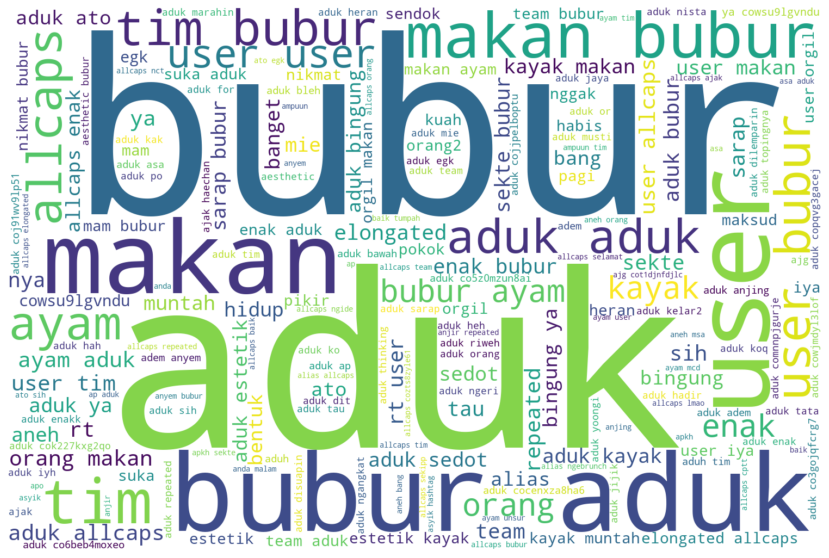

In [80]:
PlotWordCloud(d)

#Model - Naive Bayes

In [81]:
from sklearn.naive_bayes import MultinomialNB

In [82]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [83]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [84]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [85]:
classifier_nb.fit(train_x, train_label.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [86]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.9855072463768116
Accuracy Test set:  0.6666666666666666


In [87]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.9855072463768116
Recall Test set:  0.6666666666666666


In [88]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.9859747545582047
Precision Test set:  0.6634768740031898


In [89]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9855319306495357
F1 Test set:  0.662037037037037


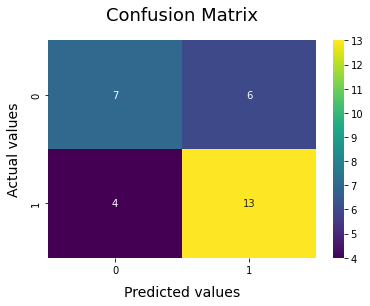

In [90]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [91]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('model', MultinomialNB(alpha=0.0001))])

In [92]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.0001
tfidf__ngram_range: (1, 2)


In [93]:
models = [        
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [94]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.985507,0.666667


In [95]:
models_comparison = [                        
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)                      
                    ]

In [96]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.666667,0.666667,0.663477,0.662037


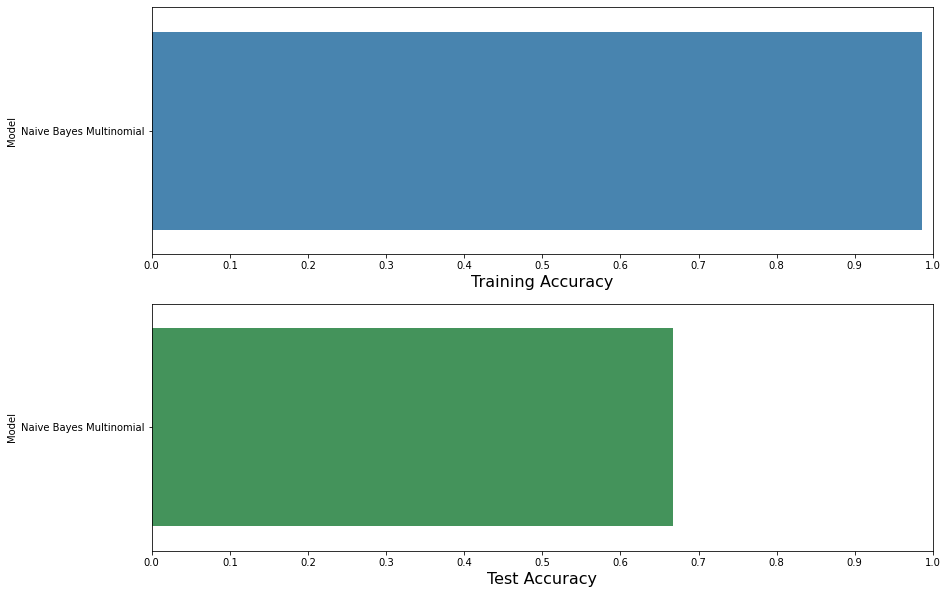

In [97]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Kesimpulan :
Dari pemodelan diatas menunjukkan hasil dengan keadaan data overfitting. Hal ini terjadi karena data training mendapat hasil akurasi 98% namun data testing hanya mendapat hasil akurasi sebesar 67%, sehingga kedua hasil akurasi tersebut tidak seimbang. selain itu, parameter terbaik yang digunakan dalam pemodelan ini yaitu (model__alpha: 0.0001, tfidf__ngram_range: (1, 2))